In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import ast
import math
import scipy.stats as stats
import preprocessing_helper

import statsmodels.formula.api as smf

In [38]:
path_lda = './Data/LdaRomances/'

characters = pd.read_csv('./Data/Preprocessed/preprocessed_characters.tsv', delimiter='\t')
summaries = pd.read_csv('./Data/MovieSummaries/plot_summaries.txt', sep="\t", names=['movie_id', 'summary'])
movies = pd.read_csv('./Data/Preprocessed/movie.metadata.augmented.tsv', delimiter='\t')

movies['genres'] = movies['genres'].apply(lambda genre : ast.literal_eval(genre))
movies['languages'] = movies['languages'].apply(lambda language : ast.literal_eval(language))
movies['countries'] = movies['countries'].apply(lambda countries : ast.literal_eval(countries))

In [39]:
def normalize(data):
    return data/np.sum(data)

def top_n_indices(data, n):
    ind = np.argpartition(data, -n)[-n:]
    ind = ind[np.argsort(data[ind])][::-1]
    return ind

In [40]:
TOP_N_WORDS = 10
topics = np.ones((30,1000))

with open(path_lda+'lda.topics.tsv') as f:
    vocabulary = np.array(f.readline().split())
    i = 0
    
    for line in f:
        topics[i] = np.array(line.split(), dtype=float)
        i += 1

In [41]:
def print_topic(i, top_words) : 
    
    ind = np.argpartition(topics[i], -top_words)[-top_words:]
    print('The top '+ str(top_words) + ' words in topic ' + str(i) + ' are :') 
    for index in top_n_indices(topics[i], top_words) : 
        a = 1
        print(vocabulary[index], int(topics[i][index]))
        
print_topic(1, TOP_N_WORDS)

The top 10 words in topic 1 are :
tell 238027
love 65337
see 45825
ask 44595
give 36212
meet 34613
confront 23552
invite 20653
call 19042
talk 17414


In [42]:
agents = np.ones((20,30))
patients = np.ones((20,30))
modifiee = np.ones((20,30))

with open(path_lda+'personas.tsv') as f:
    
    i = 0
    for line in f:
        #topics[i] = dict(zip(vocabulary, line.split()))
        data = np.array(line.split('\t')[1].split(), dtype=float)
        agents[i] = normalize(data[:30])
        patients[i] = normalize(data[30:60])
        modifiee[i] = normalize(data[60:])
        
        i += 1

In [43]:
def describe_persona(agents, patients, modifiee, persona, topics, vocab, topic_number=4):
    fig = plt.figure(figsize=(10, 2))

    plt.subplot(131)
    plt.title('Agents')
    plt.plot(agents[persona])

    plt.subplot(132)
    plt.title('Patients')
    plt.plot(patients[persona])

    plt.subplot(133)
    plt.title('Modifiee')
    plt.plot(modifiee[persona])

    fig.tight_layout()
    plt.show()

    top_agents_topics = top_n_indices(agents[persona], topic_number)
    top_patients_topics = top_n_indices(patients[persona], topic_number)
    top_modifiee_topics = top_n_indices(modifiee[persona], topic_number)

    print(f"The most important agent topics for persona {persona} are : ")
    for t in top_agents_topics : 
        top_words = top_n_indices(topics[t], 10)
        print('topic ' + str(t) + ' : ' + str(vocab[top_words]))#come here
        
    print('\n-------------------')
    print(f"The most important patient topics for persona {persona} are : ")
    for t in top_patients_topics : 
        top_words = top_n_indices(topics[t], 10)
        print('topic ' + str(t) + ' : ' + str(vocab[top_words]))

    print('\n-------------------')
    print(f"The most important modifiee topics for persona {persona} are : ")
    for t in top_modifiee_topics : 
        top_words = top_n_indices(topics[t], 10)
        print('topic ' + str(t) + ' : ' + str(vocab[top_words]))

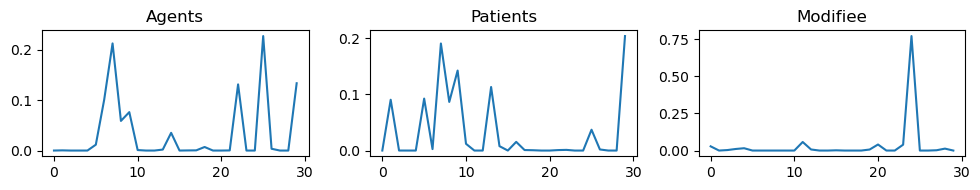

The most important agent topics for persona 1 are : 
topic 25 : ['have' 'meet' 'decide' 'be' 'try' 'begin' 'want' 'find' 'realize' 'get']
topic 7 : ['leave' 'take' 'see' 'be' 'find' 'run' 'have' 'know' 'make' 'look']
topic 29 : ['go' 'meet' 'return' 'come' 'live' 'arrive' 'join' 'stay' 'work' 'visit']
topic 22 : ['find' 'try' 'fall' 'manage' 'arrive' 'discover' 'attempt' 'refuse' 'die'
 'learn']

-------------------
The most important patient topics for persona 1 are : 
topic 29 : ['go' 'meet' 'return' 'come' 'live' 'arrive' 'join' 'stay' 'work' 'visit']
topic 7 : ['leave' 'take' 'see' 'be' 'find' 'run' 'have' 'know' 'make' 'look']
topic 9 : ['give' 'take' 'reveal' 'show' 'convince' 'offer' 'help' 'inform' 'keep'
 'hire']
topic 13 : ['marry' 'meet' 'fall' 'attract' 'send' 'name' 'engage' 'involve'
 'reunite' 'find']

-------------------
The most important modifiee topics for persona 1 are : 
topic 24 : ['boy' 'doctor' 'princess' 'worker' 'dad' 'villager' 'young' 'stranger'
 'gay' 'chri

In [44]:
describe_persona(agents, patients, modifiee, 1, topics, vocabulary)

In [45]:
def get_normalized(characters):
    characters_genres = characters.merge(movies[['movie_id', 'genres', 'movie_name']], on='movie_id', how='left')

    exploded = characters_genres.explode('genres') # obtain all the possible genres
    pivot = exploded.groupby(['persona', 'genres']).size().reset_index(name='Count')
    # pivot so we have genres as columns
    pivot = pivot.pivot(index='persona', columns='genres', values='Count').fillna(0)
    # normalize the values per column (genre) se we have values between 0 and 1
    normalized = pivot.apply(lambda x: (x-x.min())/(x.max()-x.min()), axis=0)
    return pivot, characters_genres, normalized

In [46]:
def plot_normalized(normalized):
    plt.figure(figsize=(25, 10))
    sns.heatmap(normalized, annot=False, cmap='YlGnBu', fmt='g')
    plt.title('Number of Characters by persona and genre')
    plt.show()

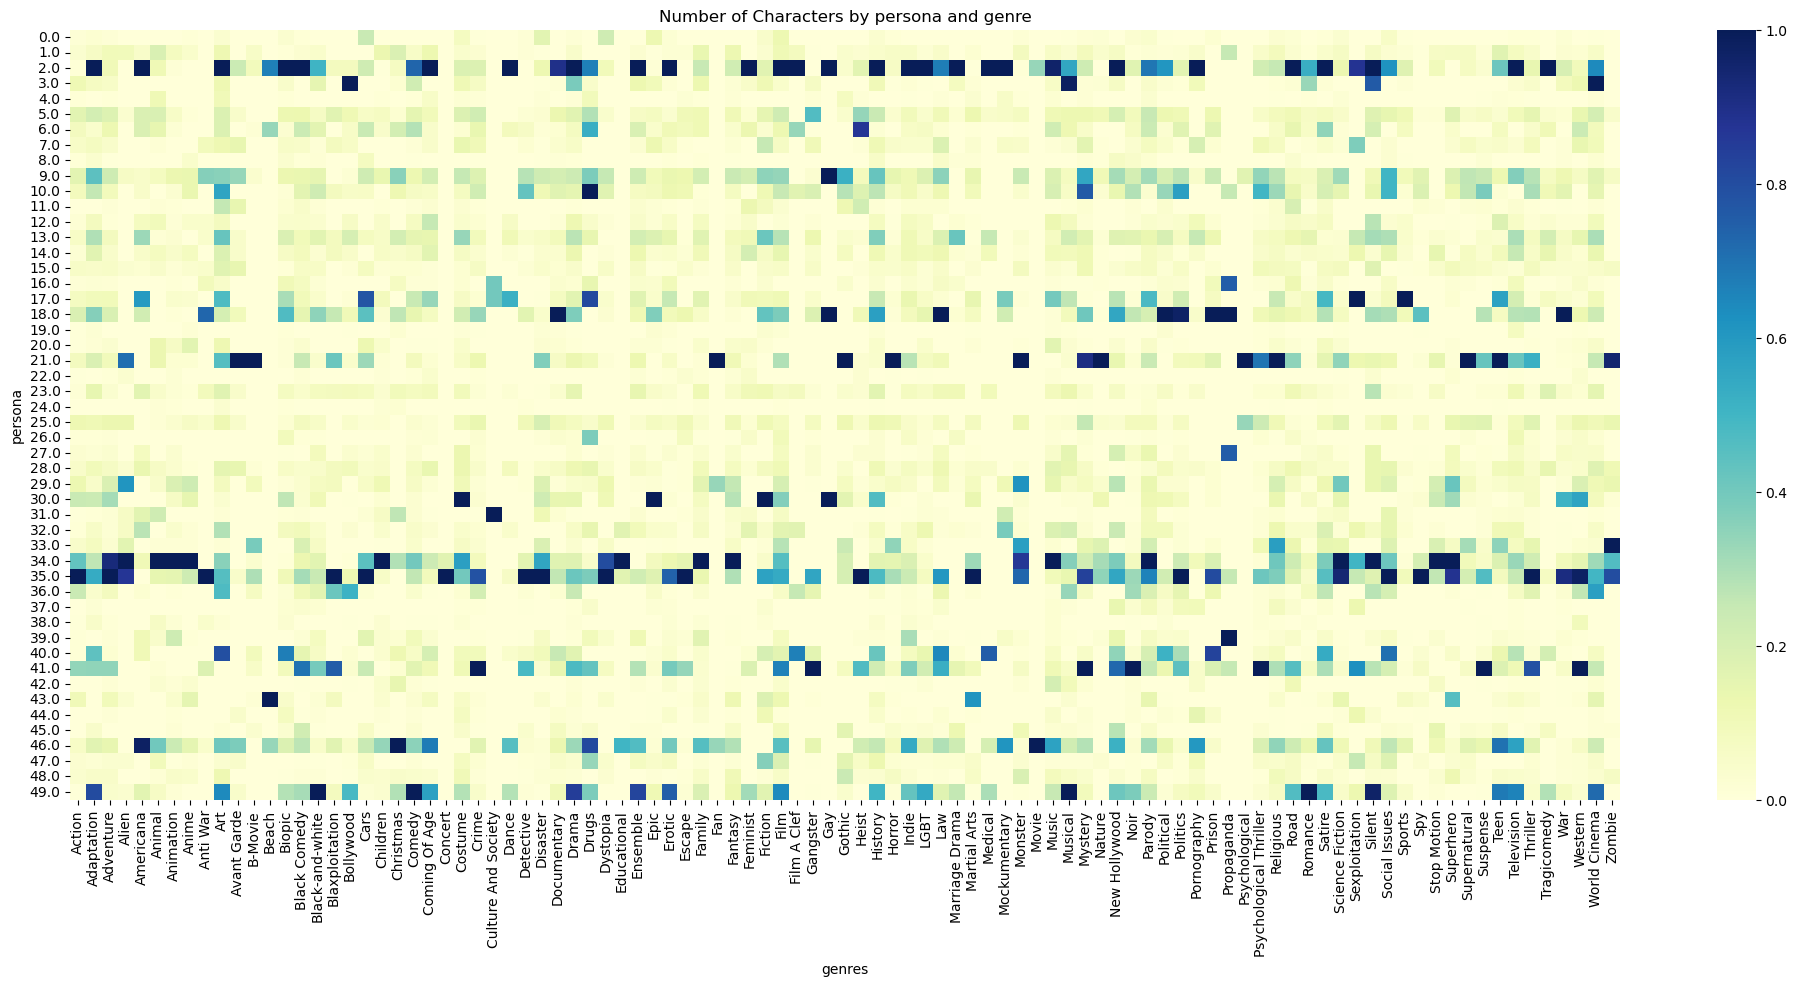

In [47]:
pivot, characters_genres, normalized = get_normalized(characters)
plot_normalized(normalized)

In [48]:
display(characters.head())

,movie_id,c_name,a_gender,a_name,a_age,c_id,a_id,movie_release,a_birth_year,persona
0,975900,Akooshay,F,Wanda De Jesus,42.0,/m/0bgcj3x,/m/03wcfv7,2001.0,1958.0,NaN
1,975900,Lieutenant Melanie Ballard,F,Natasha Henstridge,27.0,/m/0bgchn4,/m/0346l4,2001.0,1974.0,35.0
2,975900,Desolation Williams,M,Ice Cube,32.0,/m/0bgchn_,/m/01vw26l,2001.0,1969.0,NaN
3,975900,Sgt Jericho Butler,M,Jason Statham,33.0,/m/0bgchnq,/m/034hyc,2001.0,1967.0,NaN
4,975900,Bashira Kincaid,F,Clea DuVall,23.0,/m/0bgchp9,/m/01y9xg,2001.0,1977.0,NaN


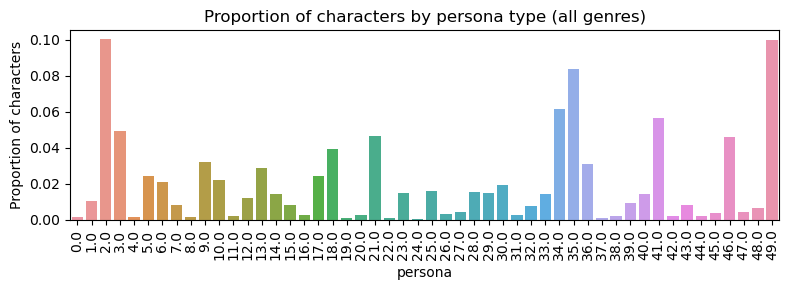

In [49]:
def plot_prop_chars_by_personas(characters_genres, all_genres=False):
    persona_count = characters_genres.groupby('persona').size().reset_index(name='Count')
    persona_total = persona_count['Count'].sum()
    persona_count['Proportion'] = persona_count['Count'].apply(lambda x: x/persona_total)

    plt.figure(figsize=(8, 3))
    sns.barplot(data=persona_count, x='persona', y='Proportion', errorbar=None)
    plt.title(f'Proportion of characters by persona type {"(all genres)" if all_genres else ""}')
    plt.xticks(rotation = 90) # Rotates X-Axis Ticks
    plt.ylabel('Proportion of characters')
    plt.tight_layout()
    plt.show()
    return persona_count
    
persona_count = plot_prop_chars_by_personas(characters_genres, all_genres=True)

In [51]:
characters = characters.dropna(subset=['persona'])
characters['persona'] = characters['persona'].apply(lambda x: int(x))

#print('nan', characters['persona'].isna().sum())

display(characters.head())   
print(characters.shape)


nan 401797
nan 0


,movie_id,c_name,a_gender,a_name,a_age,c_id,a_id,movie_release,a_birth_year,persona
1,975900,Lieutenant Melanie Ballard,F,Natasha Henstridge,27.0,/m/0bgchn4,/m/0346l4,2001.0,1974.0,35
40,2238856,Richard Swersey,M,John Hawkes,NaN,/m/0g98dqk,/m/0785v8,2005.0,1959.0,2
42,2238856,Peter Swersey,M,Miles Thompson,NaN,/m/0g98dq9,/m/0k0jml,2005.0,NaN,46
43,2238856,Robby Swersey,M,Brandon Ratcliff,NaN,/m/0g98dtr,/m/0287qtg,2005.0,1998.0,2
100,156558,Yvette,F,Taraji P. Henson,30.0,/m/03jnxj_,/m/0blbxk,2001.0,1970.0,46


(38945, 10)


one hot encoding of persona

In [74]:
import ast


unique_personas = sorted(characters['persona'].unique())
print(sorted(unique_personas))

one_hot_personas = pd.get_dummies(characters['persona'], prefix='persona', dtype=int)

characters = pd.concat([characters, one_hot_personas], axis=1)
characters.head()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


,movie_id,c_name,a_gender,a_name,a_age,c_id,a_id,movie_release,a_birth_year,persona,...,persona_40,persona_41,persona_42,persona_43,persona_44,persona_45,persona_46,persona_47,persona_48,persona_49
1,975900,Lieutenant Melanie Ballard,F,Natasha Henstridge,27.0,/m/0bgchn4,/m/0346l4,2001.0,1974.0,35,...,0,0,0,0,0,0,0,0,0,0
40,2238856,Richard Swersey,M,John Hawkes,NaN,/m/0g98dqk,/m/0785v8,2005.0,1959.0,2,...,0,0,0,0,0,0,0,0,0,0
42,2238856,Peter Swersey,M,Miles Thompson,NaN,/m/0g98dq9,/m/0k0jml,2005.0,NaN,46,...,0,0,0,0,0,0,1,0,0,0
43,2238856,Robby Swersey,M,Brandon Ratcliff,NaN,/m/0g98dtr,/m/0287qtg,2005.0,1998.0,2,...,0,0,0,0,0,0,0,0,0,0
100,156558,Yvette,F,Taraji P. Henson,30.0,/m/03jnxj_,/m/0blbxk,2001.0,1970.0,46,...,0,0,0,0,0,0,1,0,0,0


In [75]:
count = []

print(unique_personas)

for persona in unique_personas:
    count.append(characters['persona_'+str(persona)].sum())

#print(len(count), count)



[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


In [76]:
#we create a dictionary mapping genres (each genre contained in the dataframe) to number of occurrences

def get_genres(df):
    total_genres = {}
    for genres in df['genres']:
        for genre in genres:
            total_genres[genre] = total_genres.get(genre, 0)+1
    return total_genres

In [77]:
total_genres = get_genres(movies)

In [78]:
romantic = movies[movies['genres'].apply(lambda genres: 'Romance' in genres)]
len(romantic)
display(romantic)

,movie_id,movie_name,revenue,runtime,languages,countries,movie_release,genres,imdb_id,rating,nb_votes
12,6631279,Little city,NaN,93.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},1997.0,"[Drama, Ensemble, Romance, Comedy]",tt0119548,5.8,1129.0
20,175024,The Devil's Holiday,NaN,NaN,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},1930.0,"[Drama, Black-and-white, Romance]",tt0020823,6.0,238.0
22,21926710,White on Rice,NaN,82.0,{},{'/m/09c7w0': 'United States of America'},2009.0,"[Romance, Indie, Comedy]",tt0892904,6.1,545.0
27,20604092,Anbu Thozhi,NaN,NaN,{'/m/07c9s': 'Tamil Language'},{'/m/03rk0': 'India'},2007.0,[Romance],NaN,NaN,NaN
35,29528534,Anokha Rishta,NaN,180.0,{'/m/03k50': 'Hindi Language'},{'/m/03rk0': 'India'},1986.0,"[Romance, World Cinema, Bollywood, Drama, Musi...",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
81582,1673588,The Brother from Another Planet,NaN,104.0,"{'/m/02h40lc': 'English Language', '/m/06nm1':...",{'/m/09c7w0': 'United States of America'},1984.0,"[Romance, Comedy, Fantasy, Religious, Indie, S...",tt0087004,6.8,6422.0
81601,25919941,The Kreutzer Sonata,NaN,99.0,{},{'/m/09c7w0': 'United States of America'},2008.0,"[Drama, Adaptation, Romance]",tt1172063,5.6,391.0
81609,19286279,Kalai Arasi,NaN,NaN,{'/m/07c9s': 'Tamil Language'},{'/m/03rk0': 'India'},1963.0,"[Drama, Romance, Action, Science Fiction]",tt1473380,8.2,51.0
81612,24209227,"The Time, the Place and the Girl",NaN,105.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},1946.0,"[Musical, Romance, Comedy]",tt0039038,5.9,348.0


In [79]:
romance_genres = get_genres(romantic)
romance_list = list(set(romance_genres.keys())&set(pivot.columns))
len(romance_list)

94

In [80]:
display(pivot)

genres,Action,Adaptation,Adventure,Alien,Americana,Animal,Animation,Anime,Anti War,Art,...,Supernatural,Suspense,Teen,Television,Thriller,Tragicomedy,War,Western,World Cinema,Zombie
persona,,,,,,,,,,,,,,,,,,,,,
0.0,31.0,9.0,30.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,...,0.0,0.0,0.0,1.0,18.0,0.0,8.0,0.0,5.0,0.0
1.0,78.0,22.0,190.0,3.0,2.0,12.0,71.0,5.0,0.0,7.0,...,20.0,6.0,54.0,8.0,104.0,0.0,11.0,5.0,43.0,0.0
2.0,21.0,352.0,203.0,0.0,37.0,7.0,11.0,0.0,0.0,59.0,...,22.0,10.0,130.0,100.0,289.0,28.0,79.0,18.0,504.0,0.0
3.0,259.0,25.0,111.0,0.0,0.0,0.0,2.0,0.0,0.0,7.0,...,0.0,0.0,0.0,3.0,104.0,0.0,35.0,23.0,786.0,0.0
4.0,23.0,1.0,20.0,0.0,0.0,7.0,0.0,0.0,0.0,6.0,...,0.0,2.0,4.0,1.0,14.0,0.0,0.0,0.0,13.0,0.0
5.0,368.0,75.0,342.0,1.0,7.0,12.0,51.0,1.0,0.0,11.0,...,15.0,21.0,11.0,10.0,307.0,1.0,10.0,26.0,163.0,3.0
6.0,187.0,14.0,241.0,0.0,7.0,9.0,18.0,0.0,0.0,11.0,...,0.0,0.0,25.0,0.0,101.0,3.0,0.0,44.0,73.0,0.0
7.0,129.0,27.0,94.0,0.0,0.0,1.0,1.0,0.0,2.0,7.0,...,22.0,13.0,17.0,3.0,183.0,0.0,5.0,26.0,78.0,0.0
8.0,19.0,13.0,15.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,7.0,0.0,0.0,7.0,0.0,6.0,0.0,19.0,0.0


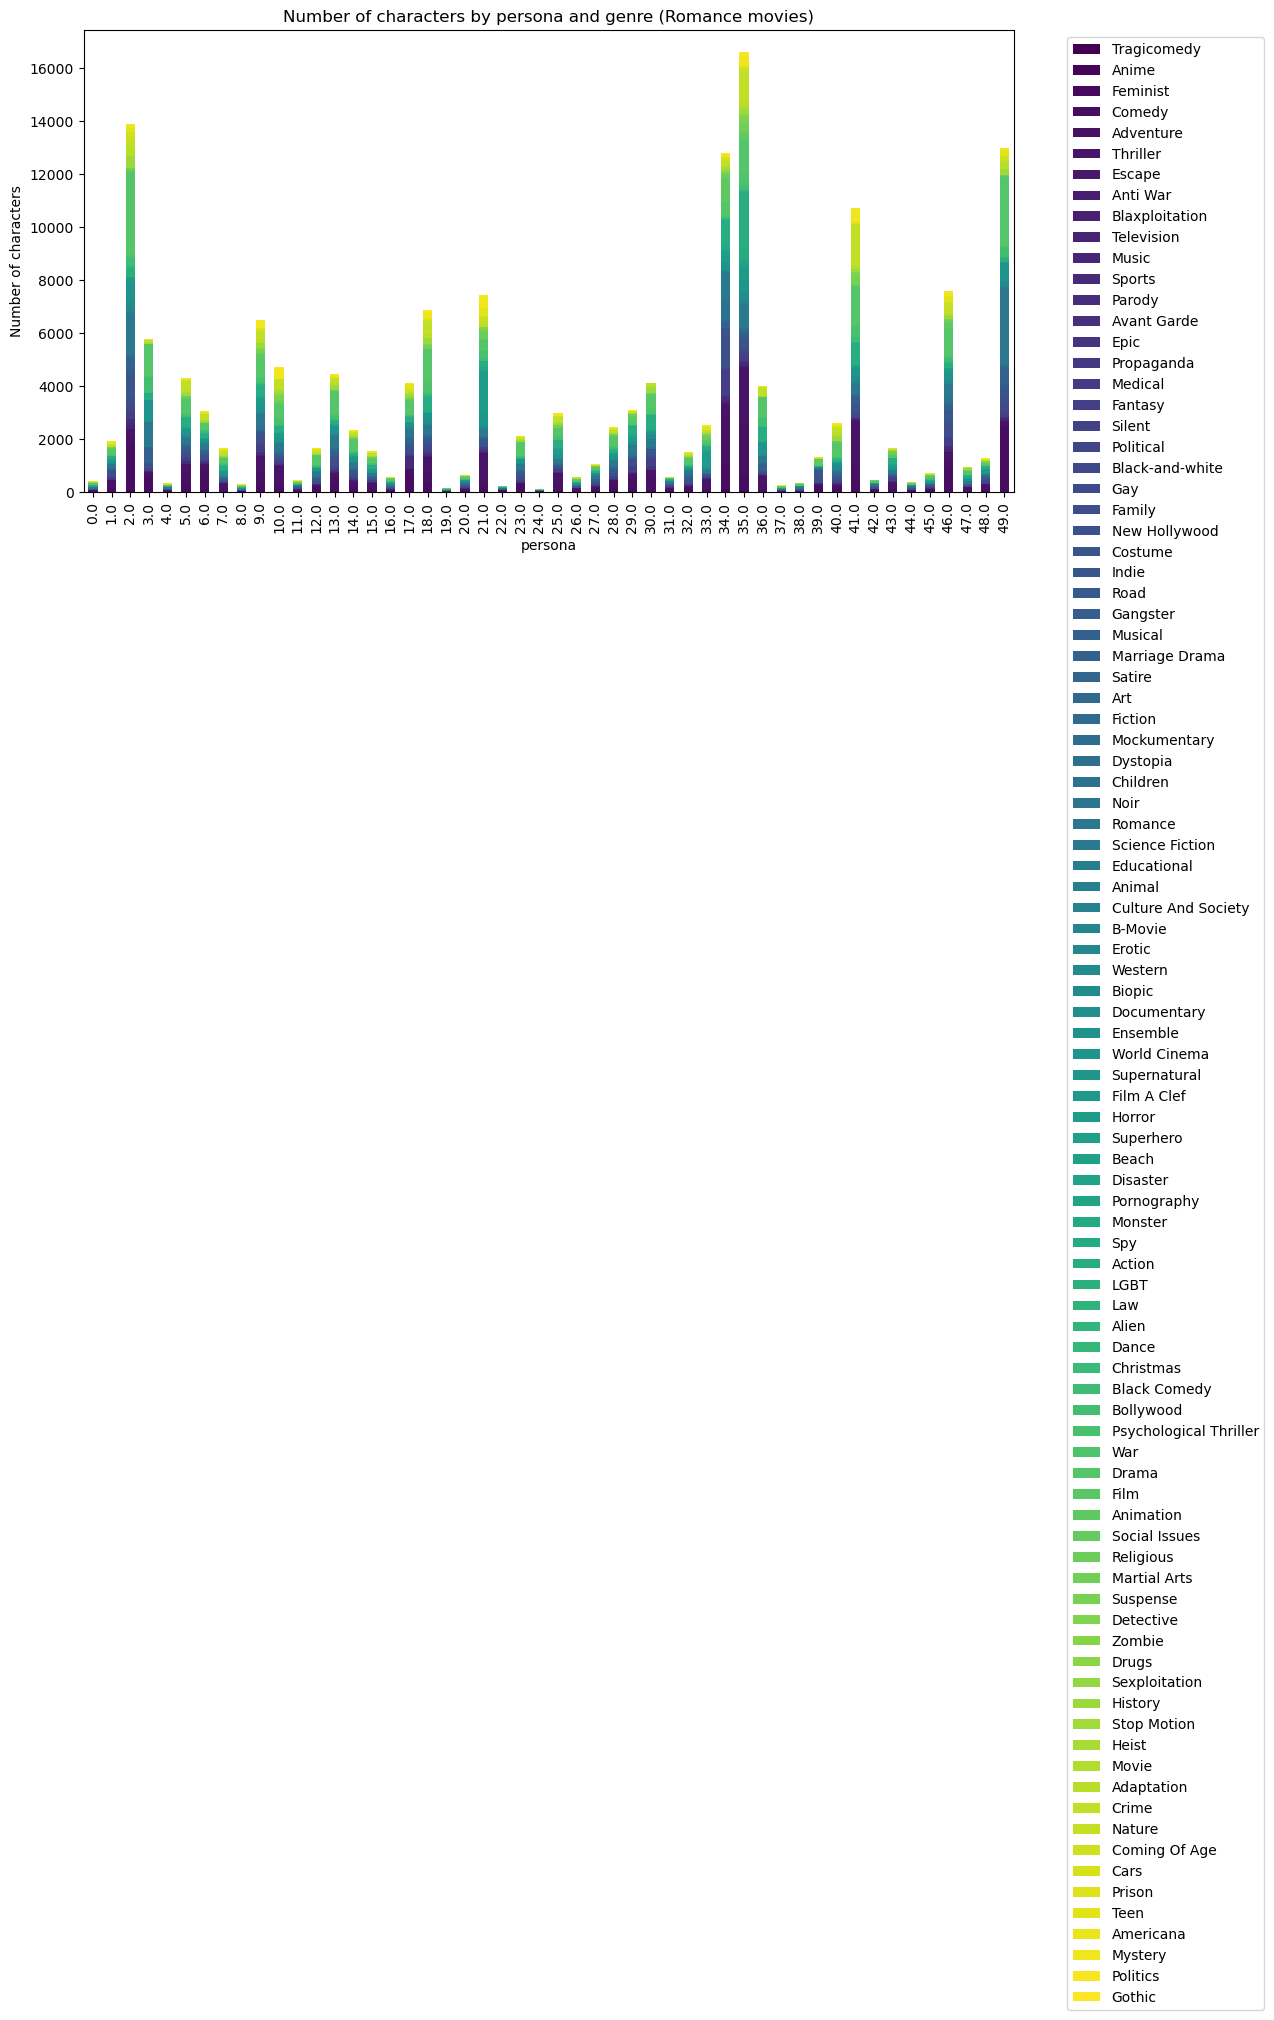

In [ ]:
pivot[romance_list].plot(kind='bar', stacked=True, colormap='viridis', figsize=(12, 6), legend=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Number of characters by persona and genre (Romance movies)')
plt.ylabel('Number of characters')
plt.show()